# Construyendo un sistema de análisis de sentimiento

## Enunciado

Se le pide que tome del corpus con el que vamos a trabajar en la práctica, HateEval (en castellano), los 10 primero tweets.

1. Haga un pequeño preproceso (todo el texto en minúsculas, sin signos de puntuación ni palabras vacias y reduzca a la raiz).

2. Obtenga las 15 palabras más frecuentes y muéstrelas en un gráfico de frecuencia

## Implementación

### Paso 1: Descargando las librerías de nltk

Importamos la librería nltk. Si no la tenemos instalada la podemos instalar mediante pip

    pip install nltk
 
Una vez importada, descargamos los paquetes necesarios: en este caso, con los conjuntos "popular" y "spanish grammars" será suficiente. El "popular" descargará los paquetes mas populares, mientras que "spanish grammars" descargará los paquetes para realizar el procesamiento de texto en español

In [1]:
import nltk


nltk.download('popular')
nltk.download('spanish_grammars')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/almu/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/almu/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/almu/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/almu/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/almu/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/almu/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk

True

### Paso 2: Cargando el corpus

Cargamos el corpus desde el fichero "trial_es.tsv". Este fichero utiliza un formato csv separado por tabulaciones.
Para este ejercicio, cargamos las 50 primeras filas, correspondientes a 50 tuits.

Para ello utilizaremos la librería pandas, con el método `read_csv()`, indicando en sus parámetros el tipo de separador y el número de filas a leer. Esto nos cargará las 10 filas en un dataframe (al que llamaremos `corpus_df`) con las mismas columnas que en el fichero original, etiquetadas por sus respectivos nombres. 

Una vez cargado, mostraremos el dataframe para comprobar que se ha cargado correctamente

In [2]:
import pandas as pd

corpus_df = pd.read_csv("HateEval/train_es.tsv", sep="\t")

print(corpus_df)

         id                                               text  HS  TR  AG
0     20001  Easyjet quiere duplicar el número de mujeres p...   1   0   0
1     20002  El gobierno debe crear un control estricto de ...   1   0   0
2     20003  Yo veo a mujeres destruidas por acoso laboral ...   0   0   0
3     20004  — Yo soy respetuoso con los demás, sólamente l...   0   0   0
4     20007  Antonio Caballero y como ser de mal gusto e ig...   0   0   0
...     ...                                                ...  ..  ..  ..
4464  24996  @miriaan_ac @Linaveso_2105 @HumildesSquad_ CÁL...   1   1   1
4465  24997  @IvanDuque presidente en Cúcuta , tenemos prob...   1   0   1
4466  24998              - Callaté Visto Que Te Dejo En Puta🎤🎶   0   0   0
4467  24999  -¿porque los hombres se casan con las mujeres?...   1   0   0
4468  25000  — No hay nada más lento que un caracol. — Cáll...   0   0   0

[4469 rows x 5 columns]


### Paso 3: Preprocesando el texto
#### 3.1. Pasando el texto a minúsculas

Empezamos el preprocesamiento del texto. Para no romper el esquema de datos, el preprocesamiento lo realizaremos sobre la misma estructura del dataframe, aprovechando la columna ya existente.

Para pasar el texto a minúsculas, utilizamos la función `lower()` de la librería estándar.
Lo aplicamos sobre cada fila de la columna 'text', en la que se almacena el texto. 

Para ello, utilizamos la función `apply()` de pandas, pasando la función en forma de lambda. Esto aplicará dicha función sobre cada fila del dataframe. 
La función `apply()` nos devuelve una copia del dataframe con las modificaciones realizadas. Almacenamos el resultado en un nuevo dataframe llamado `corpus_lower`

Finalmente, mostramos el dataframe para comprobar que el proceso ha funcionado correctamente

In [3]:
corpus_lower = corpus_df
corpus_lower['text'] = corpus_df['text'].apply(lambda text: text.lower())

print(corpus_lower)

         id                                               text  HS  TR  AG
0     20001  easyjet quiere duplicar el número de mujeres p...   1   0   0
1     20002  el gobierno debe crear un control estricto de ...   1   0   0
2     20003  yo veo a mujeres destruidas por acoso laboral ...   0   0   0
3     20004  — yo soy respetuoso con los demás, sólamente l...   0   0   0
4     20007  antonio caballero y como ser de mal gusto e ig...   0   0   0
...     ...                                                ...  ..  ..  ..
4464  24996  @miriaan_ac @linaveso_2105 @humildessquad_ cál...   1   1   1
4465  24997  @ivanduque presidente en cúcuta , tenemos prob...   1   0   1
4466  24998              - callaté visto que te dejo en puta🎤🎶   0   0   0
4467  24999  -¿porque los hombres se casan con las mujeres?...   1   0   0
4468  25000  — no hay nada más lento que un caracol. — cáll...   0   0   0

[4469 rows x 5 columns]


#### 3.2. Eliminando signos de puntuación, stopwords, y otra información irrelevante

Una vez con todo el texto en minúsculas, realizamos otro preprocesamiento para eliminar signos de puntuación y stopwords. Además de esto, por eliminar incoherencias, en nuestro caso también eliminaremos las citas a otros usuarios y las URL mencionadas.

Para estas operaciones utilizaremos las librerías nltk y re.

Empezaremos cargando el diccionario de stopwords del español, a través de la clase stopwords de nltk.

- Función `token_filter()`

    Para poder eliminar la información irrelevante de cada frase, nos creamos una función. Esta recibirá una cadena de caracteres (correspondiente al campo 'text' de una de las filas del dataframe), eliminará la información irrelevante, y devolverá una lista con los tokens filtrados.
    
    Para eliminar las URL, usuarios, y signos de puntuación; utilizaremos expresiones regulares, a través de la librería re. Las URL se describirán como subcadenas empezadas por https y terminadas por espacio o por final de cadena. Los usuarios se describirán como subcadenas empezadas por @, y terminadas por espacio o final de cadena. Y los signos de puntuación los describiremos como símbolos que no sean caracteres alfanuméricos o espacios.
    
    Una vez eliminada esta información, aplicaremos la función `word_tokenize()` sobre la cadena resultante, lo cual nos dividirá la cadena de caracteres en una lista de tokens.
    
    Para eliminar las stopwords, utilizaremos una lista en compresión que recorrerá la lista de tokens, comparándolos con la lista de stopwords de nltk, previamente cargada para el idioma español.

Finalmente, aplicamos la función anterior sobre cada fila del campo 'text' del dataframe, utilizando la función `apply()` desde pandas, y almacenamos el resultado en un nuevo dataframe llamado `corpus_filtered`


In [4]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords.words('spanish')

def token_filter(wordlist: pd.DataFrame):
    
    words_no_links = re.sub(r'http.*\s*', '', wordlist)
    words_no_users = re.sub(r'@\w*\s*', '', words_no_links)
    words_no_punct = re.sub(r'[^\w\s]', '', words_no_users)
    
    token_list = word_tokenize(words_no_punct,"spanish")
    
    words_no_stop = [word for word in token_list if word not in stopwords.words('spanish')]
    return words_no_stop
    
    
corpus_filtered = corpus_lower
corpus_filtered['text'] = corpus_lower['text'].apply(token_filter)

print(corpus_filtered)

         id                                               text  HS  TR  AG
0     20001  [easyjet, quiere, duplicar, número, mujeres, p...   1   0   0
1     20002  [gobierno, debe, crear, control, estricto, inm...   1   0   0
2     20003  [veo, mujeres, destruidas, acoso, laboral, cal...   0   0   0
3     20004  [respetuoso, demás, sólamente, recuerdo, si, e...   0   0   0
4     20007  [antonio, caballero, ser, mal, gusto, ignorant...   0   0   0
...     ...                                                ...  ..  ..  ..
4464  24996  [cállateeee, zorra, ahre, cnco, bestboyband, i...   1   1   1
4465  24997  [presidente, cúcuta, problemas, venezolanos, d...   1   0   1
4466  24998                       [callaté, visto, dejo, puta]   0   0   0
4467  24999  [hombres, casan, mujeres, cabras, saben, frega...   1   0   0
4468  25000  [lento, caracol, cállate, hijo, puta, dices, b...   0   0   0

[4469 rows x 5 columns]


#### 3.3. Reduciendo las palabras a su raíz

Una vez generados los tokens, y filtradas únicamente las palabras relevantes, aplicamos una reducción a la raíz para eliminar las derivaciones de cada palabra. Esto nos permitirá realizar una comparación mas precisa, agrupando todas las palabras con la misma raíz.

Para aplicar la reducción, utilizaremos la clase SnowballStemmer de nltk. Para aplicarlo sobre cada fila del dataframe, utilizaremos la misma estrategia que en los pasos anteriores, creando una función que procese la lista de palabras, y aplicándola sobre el dataframe a través de `apply()`

La función reducirá cada palabra, utilizando una lista por compresión conectada a la función `stem()` de SnowballStemmer de nltk. Tras el procesamiento, devolverá la lista de palabras ya reducidas

Aplicamos la función sobre el campo 'text' del dataframe, para aplicarse sobre cada fila del dataframe. El resultado lo almacenamos en un nuevo dataframe llamado `corpus_root`.

In [5]:
from nltk.stem import SnowballStemmer

sp_stemmer = SnowballStemmer('spanish')

def root_reducer(wordlist):
    root_wordlist = [sp_stemmer.stem(word) for word in wordlist]
    
    return root_wordlist

corpus_root = corpus_filtered.copy()
corpus_root['text'] = corpus_filtered['text'].apply(root_reducer)

print(corpus_root)

         id                                               text  HS  TR  AG
0     20001  [easyjet, quier, duplic, numer, mujer, pilot, ...   1   0   0
1     20002  [gobiern, deb, cre, control, estrict, inmigr, ...   1   0   0
2     20003  [veo, mujer, destru, acos, laboral, callejer, ...   0   0   0
3     20004  [respetu, demas, sol, recuerd, si, escori, cul...   0   0   0
4     20007  [antoni, caballer, ser, mal, gust, ignor, vez,...   0   0   0
...     ...                                                ...  ..  ..  ..
4464  24996  [callateee, zorr, ahre, cnco, bestboyband, ihe...   1   1   1
4465  24997  [president, cucut, problem, venezolan, disput,...   1   0   1
4466  24998                           [callat, vist, dej, put]   0   0   0
4467  24999         [hombr, cas, mujer, cabr, sab, freg, plat]   1   0   0
4468  25000  [lent, caracol, callat, hij, put, dic, blackbe...   0   0   0

[4469 rows x 5 columns]


### Paso 4: Realizando un conteo de palabras

#### 4.1. Uniendo todos los textos en una lista de palabras

En este último paso, queremos realizar un conteo de todas las palabras del conjunto, para encontrar las mas frecuentes.

Actualmente, las palabras se encuentran en los campos 'text' de cada tuit, por lo que es necesario unir el contenido de todos esos campos en una única lista.

Para facilitar este proceso, vamos a recurrir a NumPy, convirtiendo el campo 'text' del dataframe en una simple matriz de listas de palabras. Esto nos permitirá iterar sobre la misma posición a posición, e ir insertando los términos de cada fila en una nueva lista.

Para la conversión, utilizamos el método `to_numpy()` de pandas, que nos devuelve una lista con los contenidos de cada campo 'text' del dataframe. Una vez obtenidos, creamos una lista vacía, y utilizaremos un bucle que irá concatenando cada lista obtenida de cada fila de la matriz, a la lista actual. Para realizar la concatenación, utilizaremos el método `extend()`.

In [6]:
import numpy as np

corpus_array = corpus_root['text'].to_numpy()

full_wordlist = []

for row in corpus_array:
    full_wordlist.extend(row)
    
print(full_wordlist)

['easyjet', 'quier', 'duplic', 'numer', 'mujer', 'pilot', 'veras', 'aparc', 'avion', 'gobiern', 'deb', 'cre', 'control', 'estrict', 'inmigr', 'zon', 'fronteriz', 'colombi', 'q', 'despues', '208querran', 'ven', 'mas', 'veo', 'mujer', 'destru', 'acos', 'laboral', 'callejer', 'depresion', 'deb', 'violacion', 'sexual', 'maltrat', 'fisic', 'conoc', 'vari', 'suicid', 'tip', 'comport', 'machist', 'vas', 'segu', 'show', 'pobr', 'respetu', 'demas', 'sol', 'recuerd', 'si', 'escori', 'culp', 'clar', 'se', 'quien', 'tom', 'antoni', 'caballer', 'ser', 'mal', 'gust', 'ignor', 'vez', 'clar', 'mism', 'acos', 'sexual', 'violacion', 'vari', 'conduct', 'compon', 'violenci', 'sexual', 'cuant', 'hij', 'put', 'sobr', 'mund', 'pabl', 'cas', 'deb', 'estudi', 'mast', 'inmigr', 'vos', 'hac', 'peg', 'pat', 'car', 'noticiasdelaline', 'detien', 'guatapanal', 'motociclet', 'nacional', 'haitian', 'indocument', 'llor', 'lomerec', 'zorr', 'padr', 'indocument', 'realiz', 'huelg', 'hambr', 'ped', 'ser', 'liber', 'se', '

#### 4.2. Realizando el análisis de frecuencia

Finalmente, tras el preprocesamiento y la recopilación de las palabras, realizamos un análisis de frecuencia, buscando las 15 palabras mas comunes y representándolas en una gráfica

Para ello, utilizaremos la clase FreqDist de nltk, en la cual cargaremos nuestra lista de palabras.
Cob el objeto resultante, llamado `fdist`, generaremos un gráfico de las 15 palabras mas comunes, utilizando para ello el método `plot()`, y el número de palabras que queremos mostrar.

Para comprobar que los resultados sean correctos, también llamaremos al método `most_common()`, con el mismo número de palabras, que nos devolverá una lista de pares, con cada palabra y su número de ocurrencias.

Comprobamos como sus valores coinciden con los mostrados en la gráfica

[('put', 1579), ('callat', 818), ('perr', 585), ('hij', 493), ('si', 492), ('arab', 430), ('inmigr', 365), ('merec', 351), ('hac', 302), ('zorr', 293), ('q', 289), ('enseñ', 252), ('acos', 248), ('madr', 248), ('mierd', 226)]


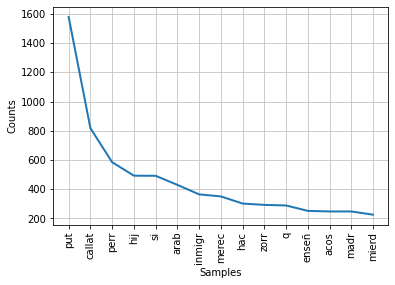

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [7]:
from nltk.probability import FreqDist
fdist=FreqDist(full_wordlist)
top_15 = fdist.most_common(15)

print(top_15)
fdist.plot(15)

# Sesión 3: Obteniendo bolsa de palabras, y calculando td-df

## Enunciado

Se le pide que tome del corpus con el que vamos a trabajar en la práctica, HateEval, los 50 primero tweets. Comience a partir del resultado obtenido tras la actividad de la sesión anterior, repitiéndola para ampliar el tamaño.

1. Obtenga el bag of words para ese mini-corpus y calcule su tf·idf

## Implementación

### Paso 1: Reagrupando tokens en frases

Para obtener la bolsa de palabras y calcular el td-df, necesitamos partir de frases, no tokens
En la sesión anterior, el filtrado se realizó después de dividir en tokens, por lo que es necesario reagrupar las palabras en frases.

Nos basaremos en el corpus filtrado, ignorando la reducción a la raíz que podría dar problemas en este proceso.
El dataframe resultante se llamará `corpus_phrases`


In [8]:
def phrase_group(wordlist):
    list_to_str = ' '.join([str(word) for word in wordlist])
    return list_to_str

corpus_phrases = corpus_filtered.copy()
corpus_phrases['text'] = corpus_filtered['text'].apply(phrase_group)

print(corpus_phrases)

         id                                               text  HS  TR  AG
0     20001  easyjet quiere duplicar número mujeres piloto ...   1   0   0
1     20002  gobierno debe crear control estricto inmigraci...   1   0   0
2     20003  veo mujeres destruidas acoso laboral callejero...   0   0   0
3     20004  respetuoso demás sólamente recuerdo si escoria...   0   0   0
4     20007  antonio caballero ser mal gusto ignorante vez ...   0   0   0
...     ...                                                ...  ..  ..  ..
4464  24996  cállateeee zorra ahre cnco bestboyband ihearta...   1   1   1
4465  24997  presidente cúcuta problemas venezolanos disput...   1   0   1
4466  24998                            callaté visto dejo puta   0   0   0
4467  24999   hombres casan mujeres cabras saben fregar platos   1   0   0
4468  25000   lento caracol cállate hijo puta dices blackberry   0   0   0

[4469 rows x 5 columns]


### Paso 2: Generando una lista de frases

En el paso anterior, realizamos la agrupación directamente sobre el dataframe, para poder mantener la relación entre el texto y el resto de datos del tuit.

Pero, para poder generar la bolsa de palabras, necesitamos utilizar una lista de frases. Para ello, utilizamos la función `to_numpy()` sobre el campo `text` del dataframe anterior.

La lista resultante la llamaremos `corpus_phrases_list`

In [9]:
corpus_phrases_list = corpus_phrases['text'].to_numpy()

print(corpus_phrases_list)

['easyjet quiere duplicar número mujeres piloto verás aparcar avión'
 'gobierno debe crear control estricto inmigración zonas fronterizas colombia q después 208querrán venir masa'
 'veo mujeres destruidas acoso laboral callejero depresión debido violación sexual maltrato físico conocí varias suicidaron tipo comportamientos machistas vas seguir show pobre'
 ... 'callaté visto dejo puta'
 'hombres casan mujeres cabras saben fregar platos'
 'lento caracol cállate hijo puta dices blackberry']


### Paso 3: Generando la bolsa de palabras

Una vez con la lista de frases, generamos la bolsa de palabras, que agrupará las palabras y obtendrá el número de ocurrencias de cada una dentro del conjunto de frases. 

Para ello, utilizaremos la clase CountVectorizer de SciKit Learn. Esta generará un diccionario relacionando cada palabra con el número de ocurrencias de la misma. A esto se le llamará "vocabulario"

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# creamos la matriz
vectorizer = CountVectorizer()

# construimos vocabulario
vectorizer.fit(corpus_phrases_list)

print(vectorizer.vocabulary_)

{'easyjet': 4586, 'quiere': 11226, 'duplicar': 4544, 'número': 9400, 'mujeres': 9034, 'piloto': 10392, 'verás': 13745, 'aparcar': 1052, 'avión': 1494, 'gobierno': 6087, 'debe': 3742, 'crear': 3405, 'control': 3252, 'estricto': 5248, 'inmigración': 7029, 'zonas': 14192, 'fronterizas': 5839, 'colombia': 2904, 'después': 4151, '208querrán': 116, 'venir': 13688, 'masa': 8402, 'veo': 13701, 'destruidas': 4168, 'acoso': 439, 'laboral': 7591, 'callejero': 2163, 'depresión': 3992, 'debido': 3757, 'violación': 13841, 'sexual': 12297, 'maltrato': 8226, 'físico': 5911, 'conocí': 3150, 'varias': 13597, 'suicidaron': 12710, 'tipo': 13040, 'comportamientos': 3030, 'machistas': 8109, 'vas': 13604, 'seguir': 12181, 'show': 12332, 'pobre': 10514, 'respetuoso': 11668, 'demás': 3943, 'sólamente': 12776, 'recuerdo': 11443, 'si': 12335, 'escoria': 5057, 'culpa': 3577, 'claro': 2785, 'sé': 12774, 'quién': 11261, 'tomas': 13118, 'antonio': 1031, 'caballero': 2023, 'ser': 12258, 'mal': 8182, 'gusto': 6285, 'i

### Paso 4: Generando la matriz de documentos

Una vez generado el vocabulario de la bolsa de palabras, generamos una matriz de documentos.
Esta mostrará, por cada documento, las palabras que aparecen y las que no. Si aparece mostrará un 1, si no aparece un 0.

Para generarla, utilizaremos el método `transform()` de la clase anterior, pasándole como parámetro la lista de frases previamente obtenida. Una vez obtenida, la mostraremos por pantalla, mostrando el tamaño de la matriz, su vocabulario, y la matriz en sí.

Vemos como, en la parte de la matriz de documentos que se nos muestra, prácticamente no hay ocurrencias de las palabras del vocabulario.

In [11]:
vector = vectorizer.transform(corpus_phrases_list)
print(vector.shape)
print(sorted(vectorizer.vocabulary_))
print(vector.toarray())

(4469, 14270)
['00', '01ago', '0347', '0348', '04', '040818', '05012018', '10', '100', '1000', '10000', '100000', '100100', '1030pm', '11', '110', '1109', '110mts', '1112', '1159', '11h00', '12', '1200', '1230', '13', '13013', '1312', '1314', '13rsw', '14', '14000', '1401', '1402', '141', '1438', '145', '148', '1492', '14cm', '15', '150', '1500', '1512', '1545564vos', '16', '16012018', '1606se', '17', '17950', '17a', '18', '180', '1808', '182837332', '1830', '18551935', '189', '19', '1930', '1953', '1960', '1967', '1970', '1984', '1986', '1989', '1999', '19dhulqhui', '19hs', '1acoso', '1agosto', '1cosa', '1decimos', '1detener', '1er', '1he', '1los', '1millon', '1º', '20', '200', '2000', '200000', '2002', '2003', '2005', '2006', '2012', '2013', '2015', '2016', '2017', '2018', '2022', '2030', '2050', '20850', '20851', '20852', '20853', '20854', '20855', '20856', '20857', '20858', '20859', '20860', '20862', '20863', '20864', '20866', '20867', '20868', '20869', '20870', '20871', '208querrá

### Paso 5: Calculando el tf-idf

La bolsa de palabras simplemente cuenta el número de ocurrencias de cada palabra. Pero ignora la importancia de dichas palabras dentro de la frase. El tf-idf permite obtener una ponderación de la importancia de cada palabra dentro de la frase, a partir de la frecuencia de aparición tanto en el propio documento como en el resto de documentos.

Esto permite valorar la importancia de cada palabra dentro del documento, de forma mucho mas precisa que el conteo anterior.

Para calcularlo, utilizaremos la clase `TfidfVectorizer` de SciKit Learn. Esta funciona de manera bastante similar a la anterior, partiendo de una lista de frases, obteniendo el vocabulario, y calculando la matriz con las ponderaciones de cada palabra dentro del documento.

El atributo `idf_` de dicha clase permitirá obtener una lista con el idf de cada palabra del vocabulario.

De forma similar al anterior, vemos que en la parte de la matriz que se nos muestra, la mayor parte de las palabras tienen una ponderación de 0, lo cual podría ser indicativo de que muchas palabras no tienen ocurrencias

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(corpus_phrases_list)

print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# codificamos como matriz de documentos, transformando
vector = vectorizer.transform(corpus_phrases_list)
# mostramos
print(vector.shape)
print(vector.toarray())

{'easyjet': 4586, 'quiere': 11226, 'duplicar': 4544, 'número': 9400, 'mujeres': 9034, 'piloto': 10392, 'verás': 13745, 'aparcar': 1052, 'avión': 1494, 'gobierno': 6087, 'debe': 3742, 'crear': 3405, 'control': 3252, 'estricto': 5248, 'inmigración': 7029, 'zonas': 14192, 'fronterizas': 5839, 'colombia': 2904, 'después': 4151, '208querrán': 116, 'venir': 13688, 'masa': 8402, 'veo': 13701, 'destruidas': 4168, 'acoso': 439, 'laboral': 7591, 'callejero': 2163, 'depresión': 3992, 'debido': 3757, 'violación': 13841, 'sexual': 12297, 'maltrato': 8226, 'físico': 5911, 'conocí': 3150, 'varias': 13597, 'suicidaron': 12710, 'tipo': 13040, 'comportamientos': 3030, 'machistas': 8109, 'vas': 13604, 'seguir': 12181, 'show': 12332, 'pobre': 10514, 'respetuoso': 11668, 'demás': 3943, 'sólamente': 12776, 'recuerdo': 11443, 'si': 12335, 'escoria': 5057, 'culpa': 3577, 'claro': 2785, 'sé': 12774, 'quién': 11261, 'tomas': 13118, 'antonio': 1031, 'caballero': 2023, 'ser': 12258, 'mal': 8182, 'gusto': 6285, 'i